In this notebook we transfer selected frames from the videos into a single HDF5 file.  
Before doing so, we flip them around both axes and resize them to 300x300.  
All these frames will be the input to our model, alongside the car distances we computed in a separate notebook.

In [1]:
import pandas as pd
from pandas.io.pytables import HDFStore
import numpy as np
import matplotlib.pyplot as plt
import cv2, os, sys, tables, time
sys.path.append('../scripts/')
import videoUtils

# Transfer frames to HDF5

The table with the file matching will help us with the left offset that we shall apply to the videos:

In [2]:
df_ord = pd.read_csv('../data/clean/files_matching.csv')
df_ord = df_ord[(~df_ord.dgps.isna()) & ~(df_ord.tesla_videos.isna() & df_ord.mercedes_videos.isna())]
df_ord.loc[:, [c for c in df_ord.columns if 'right' not in c]]

,dgps,tesla,mercedes,tesla_videos,mercedes_videos,tesla_left_offset,mercedes_left_offset
0,Thursday 1st manual.csv,2019-07-04-13-04-32.csv,2019-07-04-13-08-00.csv,V0350035.GLV,V0830086.GLV+V0830087.GLV,50.368,152.368
1,Thursday ACC max dist.csv,2019-07-04-13-04-32.csv,2019-07-04-13-44-50.csv,V0360037.GLV,V0840088.GLV,0.000,65.268
2,Thursday ACC min dist 60 90.csv,2019-07-04-14-15-08.csv,2019-07-04-14-15-16.csv,V0380039.GLV,V0850089.GLV,10.338,2.338
3,Thursday manual 50 100 inverse.csv,2019-07-04-15-34-19.csv,2019-07-04-15-34-58.csv,V0420043.GLV,V0880092.GLV,11.713,0.000
4,Thursday ACC min dist 50 100.csv,2019-07-04-14-50-23.csv,2019-07-04-14-50-58.csv,V0390040.GLV,V0860090.GLV,26.704,0.000
6,Thursday ACC min dist 50 100 with small perts.csv,2019-07-04-15-13-46.csv,2019-07-04-15-14-33.csv,V0400041.GLV,V0870091.GLV,17.746,0.000
9,Thursday ACC min dist 50 100 inverse 2.csv,NaN,2019-07-04-15-58-49.csv,NaN,V0890093.GLV,NaN,0.000


For convenience, we extract the (relevant) video names into a list:

In [3]:
videos = [video for video in df_ord.iloc[:, [3, 4]].values.reshape(-1) if not pd.isnull(video)]
videos

['V0350035.GLV',
 'V0830086.GLV+V0830087.GLV',
 'V0360037.GLV',
 'V0840088.GLV',
 'V0380039.GLV',
 'V0850089.GLV',
 'V0420043.GLV',
 'V0880092.GLV',
 'V0390040.GLV',
 'V0860090.GLV',
 'V0400041.GLV',
 'V0870091.GLV',
 'V0890093.GLV']

And process them, one by one. Notice that `V0830086.GLV+V0830087.GLV` is a special case.

In [4]:
out_path = '../data/clean/car_frames_norm.h5'
with HDFStore('../data/clean/car_distances.h5', mode='r') as store_r:
    for video in videos:
        # Obtain dataframe with the distances
        if video == 'V0830086.GLV+V0830087.GLV':
            video = 'V0830086.GLV'
            df = store_r['V0830086_V0830087']
        else:
            df = store_r[video[:-4]]
        # Number of rows in the dataframe
        tot_shape = df.shape[0]
        # Number of non-na rows in the dataframe
        non_na = df[~df.iloc[:, 1].isna()].shape[0]
        # Obtain left offset of the video based on video name
        left_offset = df_ord[df_ord.tesla_videos.str.contains(video, na=False)].tesla_left_offset
        if left_offset.empty:
            left_offset = df_ord[df_ord.mercedes_videos.str.contains(video, na=False)].mercedes_left_offset
        # Extract from the pd.Series
        left_offset = left_offset.iloc[0]

        # Path of the video file (Tesla or Mercedes)
        path = '../data/raw/day 4/DCIM/100_VIRB/'
        if not os.path.exists(path + video):
            path = path.replace('4', '4 b')
        # Total number of frames in the video and fps
        tot_frames = videoUtils.get_total_frames(path + video)
        fps = videoUtils.get_fps(path + video)
        # Call function that transforms the video into frames with the required offset
        frames_ok, frame_count = videoUtils.video_2_frames(video, path, out_path, timestep=100, 
                                                           left_offset=left_offset*1000, max_frames=non_na)

        print('Video {}'.format(video))
        print('{} frames transformed, of a total of {}'.format(frames_ok, frame_count))
        print('The dataframe has {} non-nan values, and shape {}'.format(non_na, tot_shape))
        print('The left offset is {}'.format(left_offset))
        print('In the video, the total number of frames is {:0.6}'.format(tot_frames / fps / 0.1))
        print('Original number of frames is {:0.6}, with fps {:0.6}'.format(tot_frames, fps))
        print('--------------------------------------------')

    Processed 15000 out of 15791 frames, progress: 95.0%, elapsed: 3189 secc

Video V0350035.GLV
15791 frames transformed, of a total of 15791
The dataframe has 15791 non-nan values, and shape 18000
The left offset is 50.368
In the video, the total number of frames is 18008.0
Original number of frames is 53970.0, with fps 29.97
--------------------------------------------


    Processed 15000 out of 15791 frames, progress: 95.0%, elapsed: 3280 secc

Video V0830086.GLV
15791 frames transformed, of a total of 15791
The dataframe has 15791 non-nan values, and shape 21580
The left offset is 152.368
In the video, the total number of frames is 18008.0
Original number of frames is 53970.0, with fps 29.97
--------------------------------------------


    Processed 11000 out of 11720 frames, progress: 93.87%, elapsed: 2428 sec

Video V0360037.GLV
11720 frames transformed, of a total of 11720
The dataframe has 11720 non-nan values, and shape 11720
The left offset is 0.0
In the video, the total number of frames is 11729.4
Original number of frames is 35153.0, with fps 29.97
--------------------------------------------


    Processed 12000 out of 12314 frames, progress: 97.46%, elapsed: 2606 sec

Video V0840088.GLV
12314 frames transformed, of a total of 12314
The dataframe has 12314 non-nan values, and shape 13220
The left offset is 65.268
In the video, the total number of frames is 13212.2
Original number of frames is 39597.0, with fps 29.97
--------------------------------------------


    Processed 9000 out of 9076 frames, progress: 99.17%, elapsed: 1927 sec

Video V0380039.GLV
9076 frames transformed, of a total of 9076
The dataframe has 9076 non-nan values, and shape 9450
The left offset is 10.338
In the video, the total number of frames is 9448.77
Original number of frames is 28318.0, with fps 29.97
--------------------------------------------


    Processed 9000 out of 9076 frames, progress: 99.17%, elapsed: 1977 sec

Video V0850089.GLV
9076 frames transformed, of a total of 9076
The dataframe has 9076 non-nan values, and shape 9500
The left offset is 2.338
In the video, the total number of frames is 9505.16
Original number of frames is 28487.0, with fps 29.97
--------------------------------------------


    Processed 11000 out of 11043 frames, progress: 99.62%, elapsed: 2387 sec

Video V0420043.GLV
11043 frames transformed, of a total of 11043
The dataframe has 11043 non-nan values, and shape 11160
The left offset is 11.713
In the video, the total number of frames is 11163.5
Original number of frames is 33457.0, with fps 29.97
--------------------------------------------


    Processed 12000 out of 12130 frames, progress: 98.94%, elapsed: 2697 sec

Video V0880092.GLV
12125 frames transformed, of a total of 12126
The dataframe has 12130 non-nan values, and shape 12130
The left offset is 0.0
In the video, the total number of frames is 12124.4
Original number of frames is 36337.0, with fps 29.97
--------------------------------------------


    Processed 9000 out of 9457 frames, progress: 95.18%, elapsed: 1972 sec

Video V0390040.GLV
9457 frames transformed, of a total of 9457
The dataframe has 9457 non-nan values, and shape 9730
The left offset is 26.704
In the video, the total number of frames is 9729.05
Original number of frames is 29158.0, with fps 29.97
--------------------------------------------


    Processed 9000 out of 9374 frames, progress: 96.02%, elapsed: 1974 sec

Video V0860090.GLV
9374 frames transformed, of a total of 9374
The dataframe has 9374 non-nan values, and shape 9450
The left offset is 0.0
In the video, the total number of frames is 9457.78
Original number of frames is 28345.0, with fps 29.97
--------------------------------------------


    Processed 9000 out of 9163 frames, progress: 98.23%, elapsed: 1960 sec

Video V0400041.GLV
9162 frames transformed, of a total of 9163
The dataframe has 9163 non-nan values, and shape 9340
The left offset is 17.746
In the video, the total number of frames is 9338.66
Original number of frames is 27988.0, with fps 29.97
--------------------------------------------


    Processed 8000 out of 8975 frames, progress: 89.15%, elapsed: 1784 sec

Video V0870091.GLV
8975 frames transformed, of a total of 8975
The dataframe has 8975 non-nan values, and shape 9800
The left offset is 0.0
In the video, the total number of frames is 9793.78
Original number of frames is 29352.0, with fps 29.97
--------------------------------------------


    Processed 4000 out of 4670 frames, progress: 85.67%, elapsed: 893 sec

Video V0890093.GLV
4670 frames transformed, of a total of 4670
The dataframe has 4670 non-nan values, and shape 4670
The left offset is 0.0
In the video, the total number of frames is 4677.34
Original number of frames is 14018.0, with fps 29.97
--------------------------------------------


# Check nodes in the HDF5

In [5]:
hdf5_file = tables.open_file(out_path, mode='r')
print([n for n in hdf5_file.walk_nodes()])
hdf5_file.close()

[/ (RootGroup) ''
  children := ['V0350035' (EArray), 'V0360037' (EArray), 'V0380039' (EArray), 'V0390040' (EArray), 'V0400041' (EArray), 'V0420043' (EArray), 'V0830086' (EArray), 'V0840088' (EArray), 'V0850089' (EArray), 'V0860090' (EArray), 'V0870091' (EArray), 'V0880092' (EArray), 'V0890093' (EArray)], /V0350035 (EArray(15791, 300, 300, 3), shuffle, blosc:lz4hc(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 300, 300, 3), /V0360037 (EArray(11720, 300, 300, 3), shuffle, blosc:lz4hc(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 300, 300, 3), /V0380039 (EArray(9076, 300, 300, 3), shuffle, blosc:lz4hc(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 300, 300, 3), /V0390040 (EArray(9457, 300, 300, 3), shuffle, blosc:lz4hc(9)) ''
  atom := Float32Atom(

# Shuffle frames

The following code reads the frames in batches, shuffles them and save them into a single group in a separate file:

In [38]:
# Open input and output files for distance 
dist_path = '../data/clean/car_distances_adjusted.h5'
out_dist = '../data/clean/car_distances_adjusted_shuffled.h5'
store_d = pd.HDFStore(dist_path, mode='r')
store_ds = pd.HDFStore(out_dist, mode='a', complib='blosc:lz4hc', complevel=9)

# Open input and output files for frames
frames_path = '../data/clean/car_frames_norm.h5'
out_path = '../data/clean/car_frames_norm_shuffled.h5'
store_f = pd.HDFStore(frames_path, mode='r')
filters = tables.Filters(complib='blosc:lz4hc', complevel=9)
store_fs = tables.open_file(out_path, mode='a', filters=filters)

# Dictionaries to be filled
shuffle_dict = {}
dims_dict = {}

for idx, video in enumerate(store_d):
    n_frames = store_d[video].shape[0]
    shuffled = np.random.permutation(np.arange(n_frames))
    shuffle_dict[video] = shuffled
    dims_dict[video] = n_frames

img_dtype = tables.Float32Atom()
data_shape = (0, 300, 300, 3)
chunkshape=(32, 300, 300, 3)
storage = store_fs.create_earray('/', 'frames', img_dtype, shape=data_shape, 
                                 chunkshape=chunkshape, expectedrows=sum(dims_dict.values()))
n_batches = 100
tic = time.time()

for batch in range(n_batches+1):
    frames_tot = np.empty((0,300,300,3), np.float32)
    dist_tot =  pd.DataFrame()
    for idx, video in enumerate(store_d):
        if video in ['/V0420043']:
            continue
        n_frames = dims_dict[video] // n_batches
        end_slice = (batch+1) * n_frames if batch < n_batches else dims_dict[video]
        video_idx = shuffle_dict[video][batch * n_frames:end]
        frames = store_f.get_node(video)[video_idx, :]
        frames_tot = np.vstack((frames_tot, frames))
        dist = store_d[video].iloc[video_idx]
        dist.columns = ['utc_timestamp', 'distance']
        dist_tot = pd.concat([dist_tot, dist])
    if dist_tot.shape[0] > 0:
        shuffled = np.random.permutation(np.arange(dist_tot.shape[0]))
        storage.append(frames_tot[shuffled])
        store_ds.append('/distances', dist_tot.iloc[shuffled].reset_index(drop=True),
                        format='table', append=True)
    print('\r    Processed {} out of {} batches, progress: {:0.4}%, elapsed: {} sec'.format( 
        batch+1, n_batches+1, 100 * (batch+1) / (n_batches+1), round(time.time() - tic)), end='', file=sys.stderr)

store_d.close()
store_ds.close()
store_f.close()
store_fs.close()

    Processed 101 out of 101 batches, progress: 100.0%, elapsed: 37265 sec

Quick check:

Shape of distances is (127531, 2), and shape of frames is (127531, 300, 300, 3)


,utc_timestamp,distance
88315,2019-07-04 13:55:14.713,1.679529


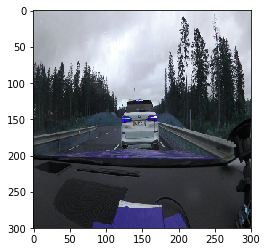

In [4]:
out_dist = '../data/clean/car_distances_adjusted_shuffled.h5'
out_path = '../data/clean/car_frames_norm_shuffled.h5'
store_ds = pd.HDFStore(out_dist, mode='r')
store_fs = tables.open_file(out_path, mode='r')
print('Shape of distances is {}, and shape of frames is {}'.format(
      store_ds['/distances'].shape, store_fs.root.frames.shape))

# Check minimum distance in the dataset
dist = store_ds['/distances'].reset_index(drop=True)
idx = dist[dist.distance == dist.distance.min()].index.values[0]
display(dist[dist.distance == dist.distance.min()])

# Plot the image
plt.imshow(store_fs.root.frames[idx, :])

store_ds.close()
store_fs.close()